# Artificial Neural Networks

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv('dataset_NN.csv')
df

,att1,att2,att3,att4,att5,att6,class
0,1.0,0.0,0.0,133.150861,1.311693,1620.221779,1
1,1.0,0.0,0.0,126.724861,1.302745,1609.334822,1
2,1.0,0.0,0.0,131.173861,1.319031,1568.978435,1
3,1.0,0.0,0.0,129.478861,1.270878,1695.055281,1
4,1.0,0.0,0.0,127.262861,1.329637,1647.720235,1
...,...,...,...,...,...,...,...
1995,1.0,1.0,1.0,157.498861,1.655794,5326.025889,10
1996,1.0,1.0,1.0,152.404861,1.620345,5243.267754,10
1997,1.0,1.0,1.0,134.672861,1.541987,3766.763222,10
1998,1.0,1.0,1.0,142.926861,1.426381,4118.327320,10


In [3]:
df['class'].value_counts()

10    200
9     200
8     200
7     200
6     200
5     200
4     200
3     200
2     200
1     200
Name: class, dtype: int64

In [4]:
X = df.values[:,:-1]
y = df.values[:, -1]

# Preprocessing

In [5]:
def train_test_split(data,split,randomize=True):
    """
    Parameters:
        data: numpy array of the dataset
        split: percentage of the samples required for the training data
        randomize: boolean representing whether you want to randomize the dataset
    Returns:
        train_X: numpy array containing training data
        train_y: numpy array containing the training labels
        test_X: numpy array containing testing data
        test_y: numpy array containing the testing labels
    """
    
    split_index = int(split*len(data))
    
    # randomly shuffles rows of the dataset
    if randomize == True:
        np.random.shuffle(data)
    
    
    X = data[:,:-1]
    y = data[:,-1]
    
    train_X = X[:split_index]
    train_y = y[:split_index]
    
    test_X = X[split_index:]
    test_y = y[split_index:]
    
    return X,y,train_X,train_y,test_X,test_y

In [6]:
X,y,train_X,train_y,test_X,test_y = train_test_split(df.values,0.7)

In [7]:
print(X.shape)
print(y.shape)
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(2000, 6)
(2000,)
(1400, 6)
(1400,)
(600, 6)
(600,)


In [8]:
def standardize(X,dataset):
    """
    Converts categorical features into one hot encoding and standardizes continuos features
    
    Parameters:
        X: numpy array of input features (either training or testing data)
        dataset: data of all training examples
        
    Returns:
        X_scaled: numpy array where categorical input features are one hot encoded and continuos features are standardized
    """
    
    X_oh = None
    
    # iterate through first three features
    for i in range(3):
        
        oh_feature = np.zeros((X.shape[0],np.unique(dataset[:,i]).shape[0]))
        
        for index, feature in enumerate(X[:,i]):
            oh_feature[index,int(feature - 1)] = 1
        
        if X_oh is not None:
            X_oh = np.concatenate((X_oh,oh_feature), axis=1)
        
        else:
            X_oh = oh_feature
            
    
    # get all continuous features
    X_continuous = X[:,3:6]
    
    # calculate mean
    X_mean = np.mean(X_continuous,axis=0)
    
    # calculate standard deviation
    X_std = np.std(X_continuous, axis=0)
    
    X_continuous = (X_continuous - X_mean)/X_std
    
    # concatenate modified features
    X_scaled = np.concatenate((X_oh,X_continuous),axis=1)    
    
    return X_scaled

In [9]:
train_X_scaled = standardize(train_X,X)
test_X_scaled = standardize(test_X,X)

In [12]:
def one_hot_labels(y):
    """
    Converts categorical features to one hot encodings
    
    Parameters:
        y: numpy array containing training or testing labels
    
    Returns:
        y_oh: one hot encoded labels
    """
    
    y_oh = np.zeros((10,y.shape[0]))
    
    for index,label in enumerate(y):
        y_oh[int(label) - 1,index] = 1
    
    return y_oh

In [13]:
train_y_oh = one_hot_labels(train_y)
test_y_oh = one_hot_labels(test_y)

# Neural Network

In [20]:
class ANN():
    
    def __init__(self,layer_dims):
        
        self.layer_dims = layer_dims
        
    def initialize_params(self):
        """
        Initializes all the weight and bias matrices of all layers given the desired neural network layer dimensions
        """

        self.parameters = {}

        for l in range(1,len(self.layer_dims)):
            self.parameters['W' + str(l)] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1])*0.01

            self.parameters['b' + str(l)] = np.random.randn(self.layer_dims[l], 1)*0.01

        
    
    def relu(self,Z):
        
        """
        Computes the ReLu activation function given the linear outputs of a layer
        
        Parameters:
            Z: numpy array containing linear outputs of a layer
        
        Returns:
            A: numpy array containing activations
            Z: numpy array containing linear outputs of the layer
        """

        A = np.maximum(0,Z)

        return A, Z

    def softmax(self,Z):
        
        """
        Computes the softmax activation function for the final layer of the neural network
        
        Parameters:
            Z: numpy array containing linear outputs of a layer
        
        Returns:
            A: numpy array of softmax activations
        """

        max_activations = np.max(Z,axis=0)

        A = np.exp(Z-max_activations)/np.sum(np.exp(Z-max_activations),axis=0,keepdims=True)

        return A,Z
    

    def relu_derivative(self,dA, cache):
        
        """
        Calculates the derivative of the ReLu function for back propagation
        
        Parameters:
            dA: numpy array containing derivatives of loss with respect to activation
        
        Returns:
            dZ: numpy array containing derivatives of loss with respect to linear outputs
        """

        Z = cache
        dZ = np.array(dA, copy=True)

        dZ[Z <= 0] = 0



        return dZ
    
    def NN_forward(self,X,parameters):
        
        """
        Computes one forward pass of the neural network
        
        Parameters:
            X: numpy array containing training data
            parameters: numpy array containing weights and biases
            
        Returns:
            A: numpy array containing probabilities for the k classes
            cache: stores the weights, biases and previous layer activations to be used for back propagation
        """

        caches = []
        A = X
        L = len(parameters) // 2

        for l in range(1,L+1):
            A_prev = A

            # linear outputs of the network
            Z = np.dot(parameters["W"+str(l)],A_prev) + parameters["b"+str(l)]
            linear_cache = (A_prev, parameters["W"+str(l)], parameters["b"+str(l)])

            # sigmoid activation for final layer and ReLu for the rest
            if l == L:
                A, activation_cache = self.softmax(Z)
            else:
                A, activation_cache = self.relu(Z)

                
            cache = (linear_cache, activation_cache)
            caches.append(cache)

        return A, caches

    
    def NN_cost(self,predictions,true):
        """
        Calculates the cost for every mini batch
        """

        m = true.shape[1]

        cost = -np.sum(np.log(np.maximum(predictions,1e-15))*true)/m

        return cost

    
    def NN_backward(self,predictions,y,caches):
        """
        Performs one backward pass of the neural network
        
        Parameters:
            predictions: numpy array consisitng predictions of the neural network over the mini batch
            y: numpy array containing ground truth labels
            caches: consists of weights, biases and activations to be used while backpropagation
        """

        grads = {}
        
        L = len(caches)
        m = predictions.shape[1]
        dZ = predictions - y

        cache = caches[L-1]
        linear_cache,activation_cache = cache
        A_prev, W, b = linear_cache


        # backpropagation for the softmax layer
        grads["dW" + str(L)] = np.dot(dZ,A_prev.T)/m
        grads["db" + str(L)] = np.sum(dZ,axis=1,keepdims=True)/m
        grads["dA" + str(L-1)] = np.dot(W.T,dZ)
    
        # backpropagation for the rest of the Relu layers
        for l in reversed(range(L-1)):
            linear_cache, activation_cache = caches[l]

            dZ = self.relu_derivative(grads["dA"+str(l+1)],activation_cache)
            A_prev,W,b = linear_cache
            m = A_prev.shape[1]
            
            dW = np.dot(dZ,A_prev.T)
            db = np.sum(dZ, axis=1, keepdims=True)/m
            dA_prev = np.dot(W.T, dZ)
            
            # gradients are stored for updating later
            grads["dA"+str(l)] = dA_prev
            grads["dW" + str(l + 1)] = dW
            grads["db" + str(l + 1)] = db

        return grads

    
    def update(self,parameters, grads, lr):
        
        """
        Updates the weights and biases of all the layers
        
        Parameters:
            parameters: dictionary containing weights and biases
            grads: dictionary containing derivatives of loss function with respect to weights and biases
            lr: learning rate
            
        Returns:
            parameters: dictionary containing updated weights and biases
        """

        L = len(parameters) // 2

        for l in range(L):

            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - lr*grads["dW"+str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - lr*grads["db"+str(l+1)]

        return parameters

    
    def minibatch_generator(self,X,y,mini_batch_size):
        
        """
        Generates minibatches for the network given the training data
        
        Parameters:
            X: numpy array containing training data
            y: numpy array containing training labels
            mini_batch_size: size of the mini batch desired
        """

        m = X.shape[1]
        mini_batches = []
        
        # dataset is shuffled every epoch
        shuffle = list(np.random.permutation(m))
        X_combination = X[:, shuffle]
        y_combination = y[:, shuffle]
        
        # mini batches which are filled
        full_minibatches = math.floor(m/mini_batch_size)

        for i in range(0, full_minibatches):
            mini_batch_X = X_combination[:, i*mini_batch_size : (i+1)*mini_batch_size]
            mini_batch_y = y_combination[:, i*mini_batch_size : (i+1)*mini_batch_size]
            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)
        
        
        # case where the final mini batch has data less than mini batch size
        if m % mini_batch_size != 0:

            mini_batch_X = X_combination[:,full_minibatches * mini_batch_size:]
            mini_batch_y = y_combination[:,full_minibatches * mini_batch_size:]

            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)

        return mini_batches
    

    def fit(self,X,y, learning_rate, epochs,mini_batch_size):
        
        """
        Trains the neural network for fixed iterations
        
        Parameters:
            X: numpy array containing training data
            y: numpy array containing training labels
            epochs: number of epochs
            
            Returns:
                cost and accuracies per epoch
        """
        
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.mini_batch_size = mini_batch_size

        self.initialize_params()

        self.costs = []
        self.accuracies = []
        
        # Repeat for number of epochs
        for epoch in tqdm(range(epochs)):
            
            # generate mini batches
            minibatches = self.minibatch_generator(X,y,self.mini_batch_size)
            
            # labels and predictions for the given epoch
            predictions = None
            labels = None
            
            # iterate through all mini batches
            for minibatch in minibatches:

                mini_batch_X,mini_batch_y = minibatch
                
                # forward pass on the mini batch
                batch_predictions, caches = self.NN_forward(mini_batch_X,self.parameters)

                # concatenate all mini batch's predictions
                if predictions is None:
                    predictions = batch_predictions
                else:
                    predictions = np.concatenate((predictions,batch_predictions),axis=1)
                
                # concatenate respective labels
                if labels is None:
                    labels = mini_batch_y
                else:
                    labels = np.concatenate((labels,mini_batch_y),axis=1)
                
                # compute cost with respect to labels and predictions
                cost = self.NN_cost(batch_predictions,mini_batch_y)
                
                # compute the gradients for back propagation
                grads = self.NN_backward(batch_predictions,mini_batch_y,caches)
                
                # update the gradients
                self.parameters = self.update(self.parameters, grads, self.learning_rate)
            
            # add the cost to the history
            self.costs.append(cost)
        

            # calculate the accuracy on the training set
            predictions_categorical = np.argmax(predictions,axis=0)
            true_categorical = np.argmax(labels,axis=0)
            accuracy = np.sum((predictions_categorical == true_categorical))/y.shape[1]
            self.accuracies.append(accuracy)


#             if (epoch+1) % 1000 == 0:
#                 print("epoch: {}".format(epoch+1))
                
#                 print("Training accuracy {:.2f}".format(accuracy*100))
                
#                 print("Cost: {}".format(cost))
#                 print()

        print("Training accuracy {:.2f}".format(self.accuracies[-1]*100))

        return {
            "costs":self.costs,
            "accuracies": self.accuracies
        }

    def predict(self,X):
        """
        predicts out of k classes given scaled input features
        """

        predictions, caches = self.NN_forward(X,self.parameters)

        return predictions

## Single Hidden Layer

  0%|                                                                                                                                                                                                                                                                               | 25/100000 [00:00<06:42, 248.26it/s]

Training accuracy 77.79
Testing accuracy: 0.71


  0%|                                                                                                                                                                                                                                                                               | 26/100000 [00:00<06:33, 253.79it/s]

Training accuracy 78.07
Testing accuracy: 0.71


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:19<00:00, 263.30it/s]


Training accuracy 32.79
Testing accuracy: 0.32


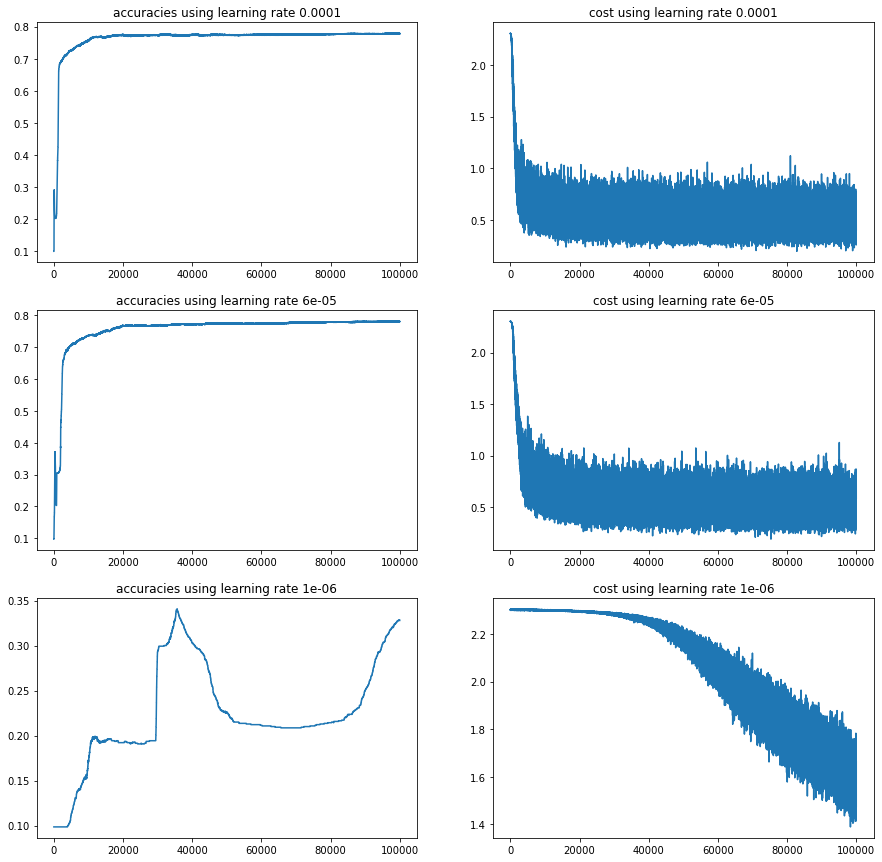

In [34]:
layer_dims = [19,15,10]
learning_rates = [0.0001,0.00006,0.000001]
epochs = 100000
batch_size = 64

fig, axes = plt.subplots(3,2,figsize=(15,15))

for i,lr in enumerate(learning_rates):
    
    ann = ANN(layer_dims)
    
    history = ann.fit(train_X_scaled.T,train_y_oh,lr,epochs,batch_size)
    
    predictions = ann.predict(test_X_scaled.T)
    
    predictions_categorical = np.argmax(predictions,axis=0)
    true_categorical = np.argmax(test_y_oh,axis=0)
    
    testing_accuracy = np.sum((predictions_categorical == true_categorical))/test_y_oh.shape[1]
    
    print("Testing accuracy: {:.2f}".format(testing_accuracy))
    
    
    axes[i,0].plot(history["accuracies"])
    axes[i,0].set_title("accuracies using learning rate {}".format(lr))
    axes[i,1].plot(history["costs"])
    axes[i,1].set_title("cost using learning rate {}".format(lr))
    



## Two hidden layers

  2%|█████▋                                                                                                                                                                                                                                                                           | 21/1000 [00:00<00:04, 206.43it/s]

Training accuracy 10.79
Testing accuracy: 0.08


  2%|██████                                                                                                                                                                                                                                                                           | 22/1000 [00:00<00:04, 215.76it/s]

Training accuracy 10.79
Testing accuracy: 0.08


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 216.00it/s]


Training accuracy 9.93
Testing accuracy: 0.10


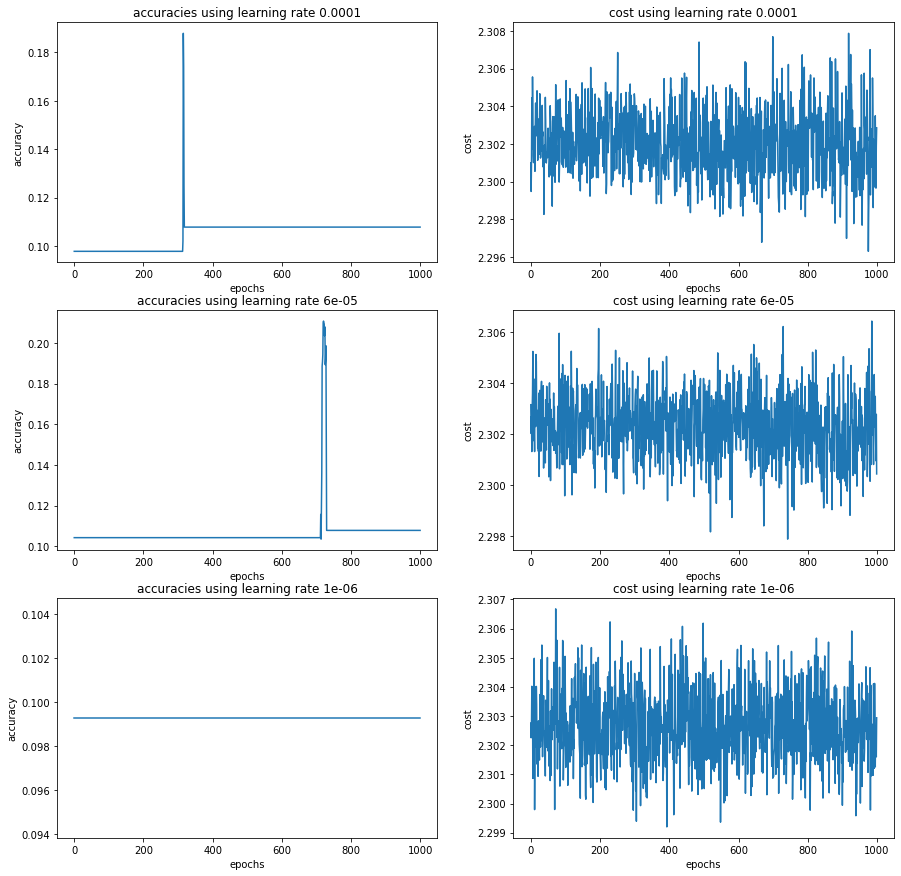

In [36]:
layer_dims = [19,18,15,10]
learning_rates = [0.0001,0.00006,0.000001]
epochs = 1000
batch_size = 64

fig, axes = plt.subplots(3,2,figsize=(15,15))

for i,lr in enumerate(learning_rates):
    
    ann = ANN(layer_dims)
    
    history = ann.fit(train_X_scaled.T,train_y_oh,lr,epochs,batch_size)
    
    predictions = ann.predict(test_X_scaled.T)
    
    predictions_categorical = np.argmax(predictions,axis=0)
    true_categorical = np.argmax(test_y_oh,axis=0)
    
    testing_accuracy = np.sum((predictions_categorical == true_categorical))/test_y_oh.shape[1]
    
    print("Testing accuracy: {:.2f}".format(testing_accuracy))
    
    
    axes[i,0].plot(history["accuracies"])
    axes[i,0].set_title("accuracies using learning rate {}".format(lr))
    axes[i,0].set(xlabel='epochs', ylabel='accuracy')
    axes[i,1].plot(history["costs"])
    axes[i,1].set_title("cost using learning rate {}".format(lr))
    axes[i,1].set(xlabel='epochs', ylabel='cost')
    
    

